<a href="https://colab.research.google.com/github/Diego-CB/DS-Proyecto/blob/main/modelo/proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo
### Predicción de argumentos efectivos
    
Grupo:
- Cristian Aguirre: 20231
- Diego Córdova: 20212
- Marco Jurado: 20308
- Paola Contreras: 20213
- Paola de León: 20361

In [23]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

## Carga de Datos de Entreno

In [24]:
id = '1kzPayZj888s0RkHlxYHGXzHwdb63fEYH'
url = 'https://drive.google.com/uc?id=' + id
data = pd.read_csv(url)
data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


## Liempieza de dataset de entreno

Se eliminaran las columnas de ***discourse_id*** y ***essay_id*** debido a que estas son solo identificadores no relevantes para el modelo. AL contrario, podrian causar ruido que genere malas predicciones.

Ademas se agrega una columna ***index*** y se guarda la columna ***discourse_text*** en una variable aparte ya que esta servira como entrada de la capa de word embedding.

Vamos a normalizar los datos para no generar ningun tipo de tendencia en el modelo pues como se ha visto en el analisis de datos los datos no estan nivelados y tenemos muchos más registros de un tipo de que de otro.

In [25]:
min_count = data['discourse_effectiveness'].value_counts().min()

# Filtrar las categorías 'adequate' y 'effective' para igualar el tamaño de 'ineffective'.
adequate_data = data[data['discourse_effectiveness'] == 'Adequate']
effective_data = data[data['discourse_effectiveness'] == 'Effective']

# Si hay más elementos que la cantidad mínima, eliminar los extras
if len(adequate_data) > min_count:
    adequate_data = adequate_data.sample(min_count, replace=False)

if len(effective_data) > min_count:
    effective_data = effective_data.sample(min_count, replace=False)

# Concatenar los DataFrames filtrados
data = pd.concat([adequate_data, effective_data, data[data['discourse_effectiveness'] == 'Ineffective']])

data.reset_index(drop=True, inplace=True)


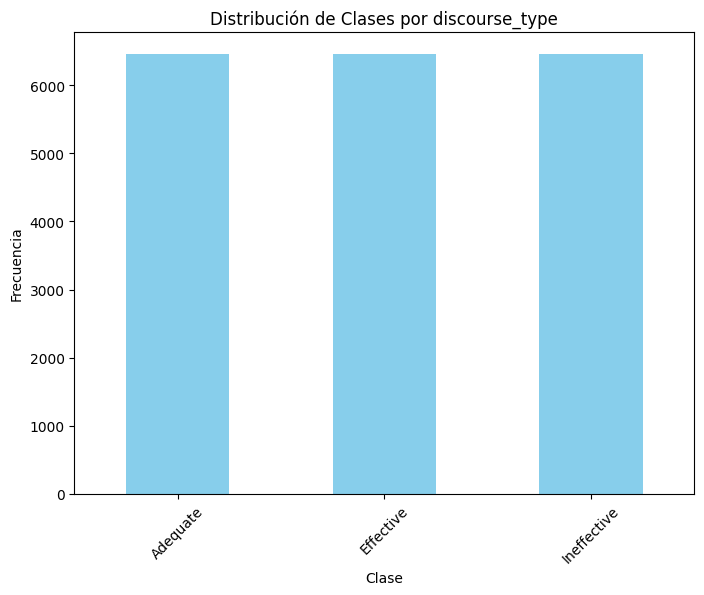

In [26]:
class_counts = data['discourse_effectiveness'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Clases por discourse_type')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [27]:
data.drop('discourse_id', axis=1, inplace=True)
data.drop('essay_id', axis=1, inplace=True)
data['index'] = data.index
data.head()

,discourse_text,discourse_type,discourse_effectiveness,index
0,the author supports the idea of studying Venus...,Position,Adequate,0
1,and the voting electors are not voting percise...,Claim,Adequate,1
2,"There are three main reasons why. One, the peo...",Claim,Adequate,2
3,For example when citizens of the united states...,Evidence,Adequate,3
4,but it sure is possible that those pictures co...,Counterclaim,Adequate,4


Se agregara una variable para obtener el tamaño en palabras del texto como input

In [28]:
claim_sizes = [len(text) for text in data['discourse_text']]
data['claim_size'] = claim_sizes
data.head()

,discourse_text,discourse_type,discourse_effectiveness,index,claim_size
0,the author supports the idea of studying Venus...,Position,Adequate,0,152
1,and the voting electors are not voting percise...,Claim,Adequate,1,50
2,"There are three main reasons why. One, the peo...",Claim,Adequate,2,165
3,For example when citizens of the united states...,Evidence,Adequate,3,608
4,but it sure is possible that those pictures co...,Counterclaim,Adequate,4,261


In [29]:
texto_original = data['discourse_text']
data.drop('discourse_text', axis=1, inplace=True)
data.head()

,discourse_type,discourse_effectiveness,index,claim_size
0,Position,Adequate,0,152
1,Claim,Adequate,1,50
2,Claim,Adequate,2,165
3,Evidence,Adequate,3,608
4,Counterclaim,Adequate,4,261


### Encoding de variables categoricas
En este caso las variables ***discourse_effectiveness*** y ***discourse_type*** son categoricas.

In [30]:
type_map = {cat:index for index, cat in enumerate(data['discourse_type'].unique())}
print('> mapa para encoding de discourse_type', type_map)
data['discourse_type'] = [type_map[cat] for cat in data['discourse_type']]
data[['discourse_type']].head()

> mapa para encoding de discourse_type {'Position': 0, 'Claim': 1, 'Evidence': 2, 'Counterclaim': 3, 'Lead': 4, 'Concluding Statement': 5, 'Rebuttal': 6}


,discourse_type
0,0
1,1
2,1
3,2
4,3


In [31]:
type_map = {cat:index for index, cat in enumerate(data['discourse_effectiveness'].unique())}
print('> mapa para encoding de discourse_effectiveness', type_map)
data['discourse_effectiveness'] = [type_map[cat] for cat in data['discourse_effectiveness']]
data[['discourse_effectiveness']].head()

> mapa para encoding de discourse_effectiveness {'Adequate': 0, 'Effective': 1, 'Ineffective': 2}


,discourse_effectiveness
0,0
1,0
2,0
3,0
4,0


In [32]:
data.head()

,discourse_type,discourse_effectiveness,index,claim_size
0,0,0,0,152
1,1,0,1,50
2,1,0,2,165
3,2,0,3,608
4,3,0,4,261


## Generacion de Secuencias de Texto



Para la capa de incrustacion se usara para realizar ***word embedding*** de los argumentos dados como input.

In [33]:
texto_original

0        the author supports the idea of studying Venus...
1        and the voting electors are not voting percise...
2        There are three main reasons why. One, the peo...
3        For example when citizens of the united states...
4        but it sure is possible that those pictures co...
                               ...                        
19381    Here are 2 of the reasons I think that the per...
19382    when are you take the video online you dont ha...
19383    Conclusion: you dont are prepared for take the...
19384    someone can use everything that many people sa...
19385    In conclusion asking for an opinion can be ben...
Name: discourse_text, Length: 19386, dtype: object

In [34]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenizar las frases
tokenizador = Tokenizer()
tokenizador.fit_on_texts(texto_original)
secuencias = tokenizador.texts_to_sequences(texto_original)

# Rellenar (Pad) las secuencias para que tengan la misma longitud
secuencias = pad_sequences(np.array(secuencias))
# Dimensiones de entrada y salida de la capa de inscrustamiento

long_vocab = len(tokenizador.word_index) + 1
dim_incrustamiento = 2  # Representar cada palabra por un vector 2D

pd.DataFrame(secuencias).head()

<ipython-input-34-db5b52c38bd0>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  secuencias = pad_sequences(np.array(secuencias))


,0,1,2,3,4,5,6,7,8,9,...,836,837,838,839,840,841,842,843,844,845
0,0,0,0,0,0,0,0,0,0,0,...,112,8033,59,67,4,966,35,1522,59,9
1,0,0,0,0,0,0,0,0,0,0,...,0,0,4,1,174,83,15,16,174,6765
2,0,0,0,0,0,0,0,0,0,0,...,3,129,7,60,10,77,1,63,2,12
3,0,0,0,0,0,0,0,0,0,0,...,37,595,8034,2516,60,8,4,8,16,63
4,0,0,0,0,0,0,0,0,0,0,...,217,2,1,1567,283,5996,45,2,1,372


## Split de Datos

In [35]:
y = data['discourse_effectiveness']
X = data.copy()
X.drop('discourse_effectiveness', axis=1, inplace=True)

In [36]:
from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

,discourse_type,index,claim_size
4049,0,4049,81
15318,0,15318,165
16717,2,16717,360
12349,6,12349,69
2688,2,2688,466
...,...,...,...
11284,2,11284,587
11964,2,11964,834
5390,2,5390,841
860,1,860,92


Se usara la columna ***index*** que creamos anteriormente para dividir los datos de texto tokenizados

In [37]:
secuencias_train = [sec for index, sec in enumerate(secuencias) if index in X_train['index']]
secuencias_test = [sec for index, sec in enumerate(secuencias) if index in X_test['index']]

Ahora se borra la columna ***index*** en los datasdets "X" luego de usarla para hacer el split en las secuencias

In [38]:
X_train.drop('index', axis=1, inplace=True)
X_test.drop('index', axis=1, inplace=True)
X_train

,discourse_type,claim_size
4049,0,81
15318,0,165
16717,2,360
12349,6,69
2688,2,466
...,...,...
11284,2,587
11964,2,834
5390,2,841
860,1,92


Se pasan a arrays de numpy para darle como input al modelo

In [39]:
X_train = X_train.values
X_test = X_test.values
X_train

array([[  0,  81],
       [  0, 165],
       [  2, 360],
       ...,
       [  2, 841],
       [  1,  92],
       [  2, 211]])

Por ultimo, se convierten las secuencias a tensores para agregarlas como input al modelo y las variables objetivo ***y_test*** y ***y_train*** se convierten a arrays de numpy

In [40]:
import tensorflow as tf

secuencias_train_list = tf.stack(secuencias_train)
secuencias_test_list = tf.stack(secuencias_test)
y_train = y_train.values
y_test = y_test.values
secuencias_train_list

<tf.Tensor: shape=(15508, 846), dtype=int32, numpy=
array([[   0,    0,    0, ...,   16,  174, 6765],
       [   0,    0,    0, ...,   63,    2,   12],
       [   0,    0,    0, ...,    2,    1,  372],
       ...,
       [   0,    0,    0, ...,  460,    1,  177],
       [   0,    0,    0, ..., 2167,    4, 4878],
       [   0,    0,    0, ...,    2,  166,  143]], dtype=int32)>

## Modelo
Capas:
1. Embedding
2. LSTM
3. Dense

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, LSTM, Dropout, GRU

# Primer Pipeline: Procesamiento de texto
text_secuence_size = len(secuencias[0])

# Capa de Word Embedding
text_inputs = Input(
    shape=(text_secuence_size,)
)
text_pipeline = Embedding(
    input_dim=text_secuence_size,
    output_dim=4,
    input_length=len(secuencias),
)(text_inputs)

# Capas LSTM
text_pipeline = LSTM(
  text_secuence_size, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1(0.01),
)(text_pipeline)
text_pipeline = Dropout(rate=0.5)(text_pipeline)

text_pipeline = LSTM(
  text_secuence_size, dropout=0.5, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l1(0.01),
)(text_pipeline)
text_pipeline = Dropout(rate=0.5)(text_pipeline)

text_pipeline = Flatten()(text_pipeline)

# Segundo Pipeline: Prediccion
predict_inputs = Input(shape=(2))
predict_pipeline = Dense(long_vocab, activation='softmax')(predict_inputs)

concat = tf.keras.layers.concatenate([text_pipeline, predict_pipeline])
dense = Dense(1, activation='softmax')(concat)

modelo = tf.keras.Model(inputs=[text_inputs, predict_inputs], outputs=dense)
modelo.compile(optimizer = 'adam', loss ='categorical_hinge', metrics=['accuracy'], run_eagerly=True)
modelo.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 846)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 846, 4)               3384      ['input_3[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, 846, 846)             2879784   ['embedding_1[0][0]']         
                                                                                                  
 dropout_2 (Dropout)         (None, 846, 846)             0         ['lstm_2[0][0]']              
                                                                                            

In [42]:
print('Largo secuencias de entreno', len(secuencias_train))
print('Largo matriz de entreno:', len(X_train))
assert len(secuencias_train) == len(X_train)

Largo secuencias de entreno 15508
Largo matriz de entreno: 15508


## Entreno del Modelo

In [43]:
secuencias_train_list

<tf.Tensor: shape=(15508, 846), dtype=int32, numpy=
array([[   0,    0,    0, ...,   16,  174, 6765],
       [   0,    0,    0, ...,   63,    2,   12],
       [   0,    0,    0, ...,    2,    1,  372],
       ...,
       [   0,    0,    0, ...,  460,    1,  177],
       [   0,    0,    0, ..., 2167,    4, 4878],
       [   0,    0,    0, ...,    2,  166,  143]], dtype=int32)>

In [44]:
modelo.fit(
    [secuencias_train_list, X_train],
    y_train,
    batch_size = 64,
    epochs = 1,
    verbose = 'auto',
    validation_data = ([secuencias_test_list, X_test], y_test)
)

243/243 [==============================] - 359s 1s/step - loss: 36.6433 - accuracy: 0.3322 - val_loss: 4.2265 - val_accuracy: 0.3378


# Funciones para Deploy

Procesar claim de entrada (texto)

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def procesar_texto(texto: str):
  ''' Necesita el Tokenizador creado arriba '''

  # Tokenizar las frase
  secuencia = tokenizador.texts_to_sequences(texto)

  # Rellenar (Pad) las secuencias para que tengan la misma longitud
  secuencia = pad_sequences(np.array(secuencia)).T
  tensor_secuencias = tf.stack(secuencias_train)
  claim_size = len(texto)
  return secuencia, claim_size

Procesar tipo de claim

In [46]:
claim_map = {'Lead': 0, 'Position': 1, 'Claim': 2, 'Evidence': 3, 'Counterclaim': 4, 'Rebuttal': 5, 'Concluding Statement': 6}

def procesar_claim(claim: str):
  '''
  Se usa el diccionario de arriba como "encoder"
  '''
  if claim not in claim_map.keys():
    raise Exception(f'tipo de argumento \'{claim}\' no aceptado')

  encoded_claim = claim_map[claim]
  return encoded_claim

Para pasarle como input al modelo debe estar como una matriz de la siguiente manera

[
  secuencias generadas,
  [
    tipo de claim,
    tamaño del claim
  ]
]

In [47]:
# Ejemplo

texto_claim = 'asdasdasadasd'
tipo_claim = 'Counterclaim'

secuencias, size_claim = procesar_texto(texto_claim)
tipo_encoded = procesar_claim(tipo_claim)

input = [
    secuencias,
    np.array([tipo_encoded, size_claim])
]
input

[array([[  3, 481, 830,   3, 481, 830,   3, 481,   3, 830,   3, 481, 830]],
       dtype=int32),
 array([ 4, 13])]

Ese array de input se le pasa al modelo para la prediccion